In [0]:
# !apt-get install -y -qq software-properties-common module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth 
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials 
# creds = GoogleCredentials.get_application_default()
# import getpass 
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass() 
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# print ('Files in Drive:')
# !ls drive/

In [0]:
import os
import math
import pprint
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

# from google.colab import files
# uploaded = files.upload()
# from google.colab import drive 
# drive.mount('/content/gdrive')

### Clean Response Variable

In [3]:
df = pd.read_csv('drive/Colab Notebooks/2018_5k.csv', sep=",", header=None)
display(df.head())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768
0,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,+23
1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,-17
2,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,+50
3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,-39
4,0,0,0,-1,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,+39


In [4]:
df.iloc[:,:-1] = df.iloc[:,:-1].astype(int)
df.iloc[:,-1] = df.iloc[:,-1].astype(str)

# remove prepended # symbols
df.iloc[:,-1] = df.iloc[:,-1].apply(lambda x : x[1:] if x.startswith("#") else x) 

# remove prepended + and - symbols, and convert to int
for idx, row in df.iterrows():
    if idx % 50000 == 0:
        print(f"cleaned {idx} rows")
    if row[768].startswith('+'):
        df.at[idx, 768] = float(row[768][1:])
    elif row[768].startswith('-'):
        df.at[idx, 768] = -float(row[768][1:])
    else:
        df.at[idx, 768] = float(row[768])

cleaned 0 rows
cleaned 50000 rows
cleaned 100000 rows
cleaned 150000 rows
cleaned 200000 rows
cleaned 250000 rows
cleaned 300000 rows
cleaned 350000 rows


### Remove Ruplicate Rows

In [5]:
print('# rows with duplicates: ', len(df))
df = df.drop_duplicates(keep='first')
print('# rows without duplicates: ', len(df))

# rows with duplicates:  371227
# rows without duplicates:  337583


### Split into Features (X) and Response (y); Plot Response Histogram

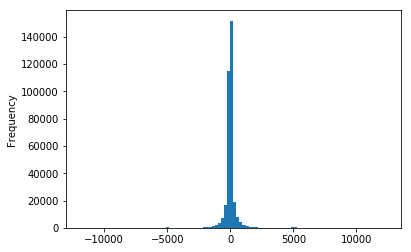

In [6]:
features = df.iloc[:,:-1]
response = df.iloc[:,-1]

response.plot(kind='hist', bins=100)
plt.show()

### Train / Test Split; MinMax Normalization

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.3)

min_ = min(y_train)
max_ = max(y_train)
range_ = max_ - min_

y_train = y_train.apply(lambda x: (x-min_)/(range_))
y_test = y_test.apply(lambda x: (x-min_)/(range_))

## MLP Trained with TPU Accelerator

In [8]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
    TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
    TF_MASTER=''

with tf.Session(TF_MASTER) as session:
    print ('List of devices:')
    pprint.pprint(session.list_devices())

List of devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 13314004317364484931),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14363130397589211186),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4654867673748458602),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4097510196314765798),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 467538749630417114),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7693285573158152169),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4829454177260059178),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 4905518026329841618),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 9633124685449907631),
 _DeviceAttributes(/job:tpu_w

In [9]:
def get_model():
    return keras.Sequential([
        keras.layers.Dense(2048, input_dim=768, activation=tf.nn.elu),
        keras.layers.Dense(2048, activation=tf.nn.elu),
        keras.layers.Dense(2048, activation=tf.nn.elu),
        keras.layers.Dense(1)
    ])

model = get_model()
model.summary()
model.compile(optimizer=tf.train.GradientDescentOptimizer(.001),
             loss='mean_squared_error',
             metrics=['mean_squared_error'],
             epsilon = 0.00000001,
             nesterov=0.7)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 9,969,665
Trainable params: 9,969,665
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


In [10]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TF_MASTER)))

history = tpu_model.fit(X_train, y_train, epochs=10, batch_size=256)
tpu_model.save_weights('/tmp/weights.h5', overwrite=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.45.254.122:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13314004317364484931)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 14363130397589211186)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4654867673748458602)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU

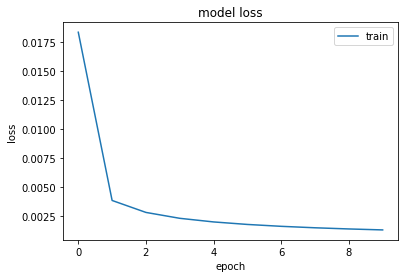

In [11]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [12]:
prediction_model = get_model()
prediction_model.load_weights('/tmp/weights.h5')

y_pred = prediction_model.predict(X_test)

print('The RMSE squared is: ' + str(sqrt(mean_squared_error(y_test, y_pred))))
print('The Mean Absolute Error is: ' + str(mean_absolute_error(y_test, y_pred)))
print('The Median Absolute Error is: ' + str(median_absolute_error(y_test, y_pred)))

The RMSE squared is: 0.03527476995616494
The MAE is: 0.02320067921004651
The median absolute error is: 0.015890494128577237


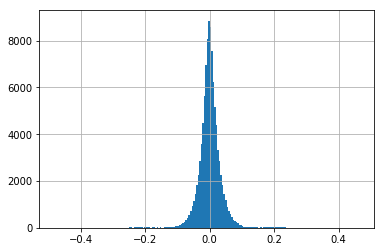

In [38]:
residuals = pd.Series(y_test.values - y_pred[:,0])
residuals.hist(bins=200);

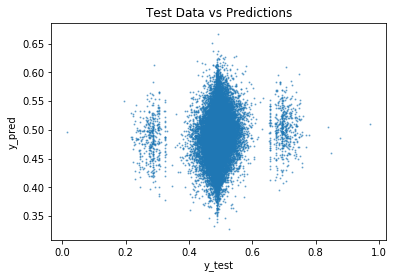

In [42]:
plt.scatter(y_test, y_pred, s=1, alpha=0.5);
plt.title('Test Data vs Predictions')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

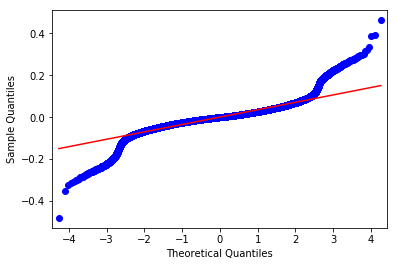

In [46]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='s');